<a href="https://colab.research.google.com/github/asadyousuf-dare/Thesis-work/blob/main/DNN_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%ls

LearningVariables.xlsx  LearningY.xlsx


In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, suppress=True)

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.8.0


In [9]:
x_train = pd.read_excel('LearningVariables.xlsx')
x_labels = pd.read_excel('LearningY.xlsx')
test_input=pd.read_excel('LearningVariables.xlsx',sheet_name='X_cv')
test_output=pd.read_excel('LearningY.xlsx',sheet_name='X_cv')

In [23]:
train_data=pd.concat([x_train,x_labels], axis=1)
test_data=pd.concat([test_input, test_output], axis=1)

In [29]:
raw_dataset = train_data

In [30]:
dataset = raw_dataset.copy()
dataset.tail()

,fc20,fy20,cover,depth,area,MR
1995,45.04625,326.575,0.06181,0.26540,0.000534,35190.350276
1996,51.41625,340.525,0.05461,0.29724,0.000349,28731.341444
1997,73.61375,487.225,0.03665,0.27276,0.000134,15422.047412
1998,71.20875,660.925,0.04467,0.18876,0.000391,36791.432479
1999,18.39625,785.575,0.05543,0.25428,0.000468,69494.760199


In [31]:
dataset.isna().sum()

fc20     400
fy20     400
cover    400
depth    400
area     400
MR         0
dtype: int64

In [32]:
dataset = dataset.dropna()

In [33]:
dataset.isna().sum()

fc20     0
fy20     0
cover    0
depth    0
area     0
MR       0
dtype: int64

In [34]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

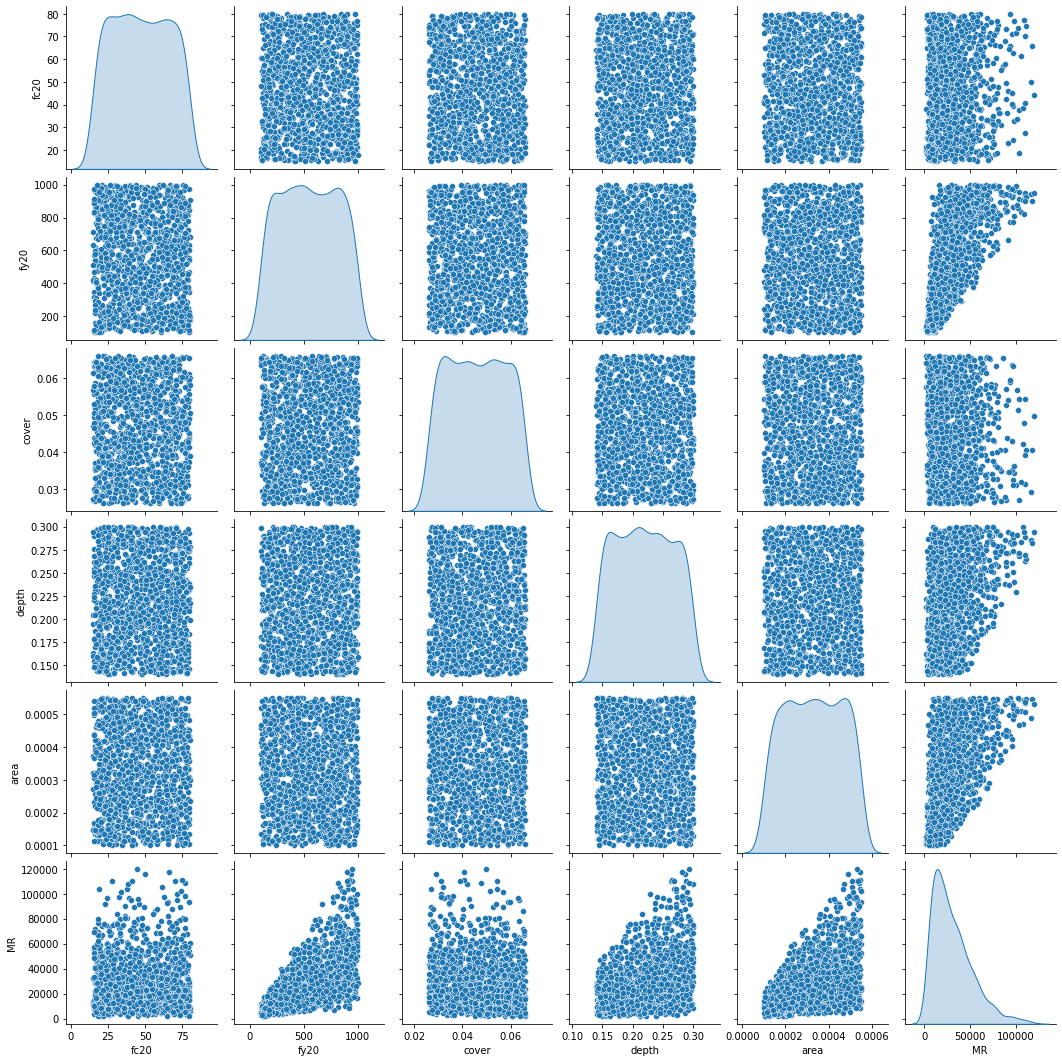

In [35]:
sns.pairplot(train_dataset, diag_kind='kde')

In [36]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fc20,1280.0,47.220297,18.790501,15.016250,30.835625,46.947500,63.676875,79.983750
fy20,1280.0,548.962539,259.997804,100.675000,329.387500,543.700000,777.137500,999.325000
cover,1280.0,0.045955,0.011666,0.026010,0.035680,0.045820,0.056060,0.065990
depth,1280.0,0.219092,0.046259,0.140040,0.178980,0.218000,0.258560,0.299880
area,1280.0,0.000329,0.000129,0.000100,0.000218,0.000329,0.000443,0.000550
MR,1280.0,30707.148550,21910.032354,1711.026896,13743.895747,25281.455774,42087.431696,120039.686055


In [62]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = (train_features.pop('MR'))//1000
test_labels = (test_features.pop('MR'))//1000

In [66]:
train_labels /= 1000
test_labels /= 1000

In [67]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
fc20,47.220297,18.790501
fy20,548.962539,259.997804
cover,0.045955,0.011666
depth,0.219092,0.046259
area,0.000329,0.000129
MR,30707.148550,21910.032354


In [68]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [69]:
normalizer.adapt(np.array(train_features))

In [70]:
print(normalizer.mean.numpy())

[[ 47.22  548.962   0.046   0.219   0.   ]]


In [71]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 40.01 217.68   0.04   0.16   0.  ]]

Normalized: [[-0.38 -1.27 -0.77 -1.36  0.84]]


In [72]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [73]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [74]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 7.81 s, sys: 591 ms, total: 8.4 s
Wall time: 7.79 s


In [75]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.026769,0.033540,95
96,0.024529,0.026886,96
97,0.016695,0.033174,97
98,0.042285,0.054332,98
99,0.036127,0.042970,99


In [76]:
history_dict = history.history.values

In [106]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training_loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([-.5, 0.4])
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute error [MAE]')
  plt.legend()
  plt.grid(True)
  plt.title('Learning_Curve[MR]')

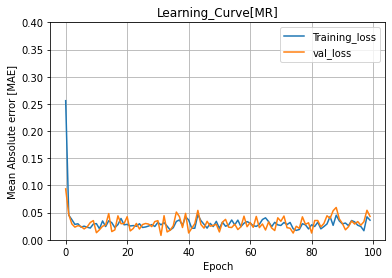

In [94]:
plot_loss(history)


In [102]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [103]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                384       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [104]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 9.31 s, sys: 696 ms, total: 10 s
Wall time: 10.7 s


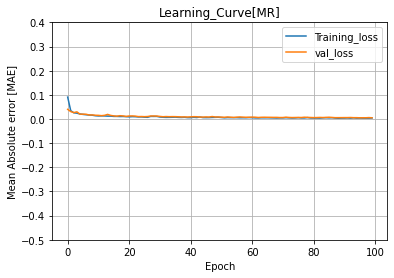

In [107]:
plot_loss(history)

In [111]:
test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [119]:
Y_pred = dnn_model.predict(test_features)

In [120]:
Y_test = test_labels

In [121]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [122]:
R_square=r2_score(Y_test,Y_pred)
rmse=np.sqrt(mean_squared_error(Y_pred,Y_test))
mae=mean_absolute_error(Y_pred,Y_test)

In [123]:
print("The computed root mean squared error is = ",rmse)
print("The computed mean absolute error is = ",mae)
print("The r2 measure for the model is = ",R_square)

The computed root mean squared error is =  0.006415942496940996
The computed mean absolute error is =  0.004925933631966473
The r2 measure for the model is =  0.0


In [135]:
plt.figure(figsize=(6,8))
plt.scatter(Y_test, Y_pred, c='blue',label='Reference Line')
plt.plot(Y_test,Y_test, color='red', linewidth=2,label="Model Prediction")
plt.xlabel('Y_test')
plt.ylabel('Y_pred')
plt.tight_layout()
plt.legend()
textstr = '$R^{2}=%.2f$' % R_square
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(2, 8, textstr, fontsize=18,
        verticalalignment='top', bbox=props)
plt.show()

ValueError: ignored

<Figure size 432x576 with 1 Axes>